# **Complete ML pipeline for churn prediction**

## Loading dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, roc_curve, auc, 
                           classification_report, RocCurveDisplay)
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seed for reproductibility
np.random.seed(42)

# Create a realistic customer churn dataset
n_samples = 2000
n_features = 10

# Generate synthetic dataset
X, y = make_classification(
    n_samples = n_samples,
    n_features = n_features,
    n_informative = 8, #8 meaningful features
    n_redundant = 2, # 2 features that are linear combinations of informative ones
    n_clusters_per_class = 1, # single cluster per class
    flip_y = 0.05, # 5% label noise to make it more realistic
    random_state = 42
)

# Create meaningful features names for our customer churn dataset
feature_names = [
    'age',
    'monthly_charges',
    'tenure_months',
    'total_charges',
    'customer_service_calls',
    'online_security',
    'tech_support',
    'contract_type',
    'payment_method',
    'internet_service'
]

# Create Dataframe with feature scaling and transformations
df = pd.DataFrame(X, columns = feature_names)

# Transform features to mre realistic 
df['age'] = (df['age'] * 15+35).astype(int) # Ages 20-50
df['monthly_charges'] = (df['monthly_charges'] * 30 + 50)  # $20-80 monthly charges
df['tenure_months'] = (df['tenure_months'] * 30 + 1).astype(int)  # 1-60 months tenure
df['total_charges'] = df['monthly_charges'] * df['tenure_months']
df['customer_service_calls'] = (df['customer_service_calls'] * 3 + 1).astype(int)  # 1-10 calls
df['online_security'] = (df['online_security'] > 0).astype(int)  # Binary feature
df['tech_support'] = (df['tech_support'] > 0).astype(int)  # Binary feature
df['contract_type'] = ((df['contract_type'] * 2 + 1).astype(int)) % 3  # 0,1,2 for contract types
df['payment_method'] = ((df['payment_method'] * 3 + 1).astype(int)) % 4  # 0,1,2,3 for payment methods
df['internet_service'] = ((df['internet_service'] * 2 + 1).astype(int)) % 3  # 0,1,2 for internet service types

# Add target variable with meaningful name
df['churn'] = y

print("Dataset created successfully!")
print(f"Dataset shape: {df.shape}" )
print(f"Churn rate: {df['churn'].mean():.2%}")  # churn rate is around 50% that means balanced dataset

Dataset created successfully!
Dataset shape: (2000, 11)
Churn rate: 49.85%


## **Exploratory Data Analysis (EDA)**

In [4]:
# Basics dataset information

print("===DATASET OVERVIEW===")
df.info()

===DATASET OVERVIEW===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     2000 non-null   int64  
 1   monthly_charges         2000 non-null   float64
 2   tenure_months           2000 non-null   int64  
 3   total_charges           2000 non-null   float64
 4   customer_service_calls  2000 non-null   int64  
 5   online_security         2000 non-null   int64  
 6   tech_support            2000 non-null   int64  
 7   contract_type           2000 non-null   int64  
 8   payment_method          2000 non-null   int64  
 9   internet_service        2000 non-null   int64  
 10  churn                   2000 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 172.0 KB


In [5]:
print("\n===FIRST 5 ROWS OF THE DATASET===")
df.head()


===FIRST 5 ROWS OF THE DATASET===


,age,monthly_charges,tenure_months,total_charges,customer_service_calls,online_security,tech_support,contract_type,payment_method,internet_service,churn
0,49,88.063767,-2,-176.127535,4,1,0,0,3,2,1
1,25,118.992418,-25,-2974.810462,8,0,1,0,1,1,1
2,26,156.302075,-55,-8596.614148,0,0,1,0,0,2,0
3,0,103.243340,-53,-5471.897022,-6,1,1,0,0,2,0
4,55,88.153575,0,0.000000,6,1,0,2,0,1,0


In [6]:
# Check for missing values
print("\n===MISSING VALUES PER COLUMN===")
df.isnull().sum()


===MISSING VALUES PER COLUMN===


age                       0
monthly_charges           0
tenure_months             0
total_charges             0
customer_service_calls    0
online_security           0
tech_support              0
contract_type             0
payment_method            0
internet_service          0
churn                     0
dtype: int64

In [7]:
# Class distribution
print("\n===CLASS DISTRIBUTION===")
print(f"Churn rate: {df['churn'].mean():.2%}")
print(f"Non-churn: {sum(df['churn'] == 0)}")
print(f"Churn: {sum(df['churn'] == 1)}")


===CLASS DISTRIBUTION===
Churn rate: 49.85%
Non-churn: 1003
Churn: 997


([<matplotlib.axis.XTick at 0x1bd17e33c80>,
 [Text(0, 0, 'No Churn'), Text(1, 0, 'Churn')])

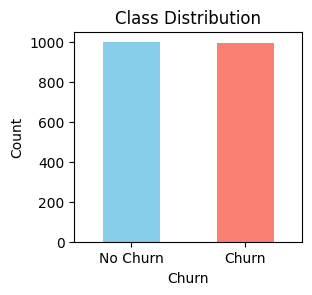

In [8]:
# Visualize class distribution
plt.figure(figsize=(10,6))

plt.subplot(2,3,1)  # 2 rows, 3 columns, 1st subplot
df['churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0,1], ['No Churn', 'Churn'], rotation=0)
# plt.show()

Text(0.5, 1.0, 'Monthly Charges Distribution by Churn')

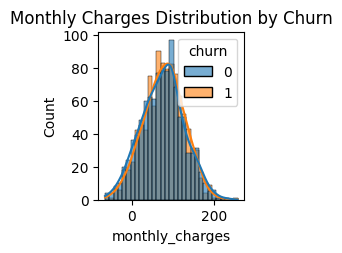

In [9]:
# Feature distrubutions for churn vs non-churn

plt.subplot(2,3,2)
sns.histplot(data=df, x='monthly_charges', hue='churn', kde=True, alpha=0.6)
plt.title('Monthly Charges Distribution by Churn')

Text(0.5, 1.0, 'Tenure Distribution')

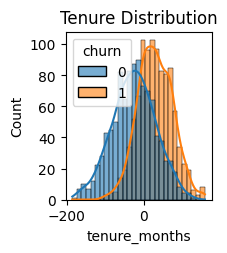

In [10]:
plt.subplot(2, 3, 3)
sns.histplot(data=df, x='tenure_months', hue='churn', kde=True, alpha=0.6)
plt.title('Tenure Distribution')

Text(0.5, 1.0, 'Customer Service Calls')

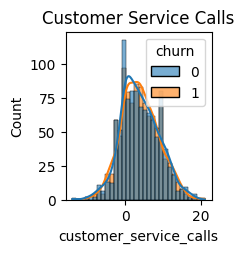

In [11]:
plt.subplot(2, 3, 4)
sns.histplot(data=df, x='customer_service_calls', hue='churn', kde=True, alpha=0.6)
plt.title('Customer Service Calls')

Text(0.5, 1.0, 'Online Security vs Churn')

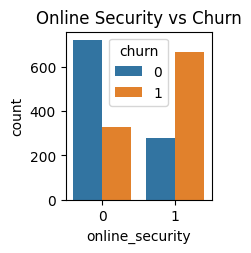

In [13]:
plt.subplot(2, 3, 5)
sns.countplot(data=df, x='online_security', hue='churn')
plt.title('Online Security vs Churn')

Text(0.5, 1.0, 'Tech Support vs Churn')

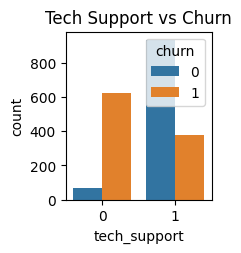

In [12]:
plt.subplot(2, 3, 6)
sns.countplot(data=df, x='tech_support', hue='churn')
plt.title('Tech Support vs Churn')

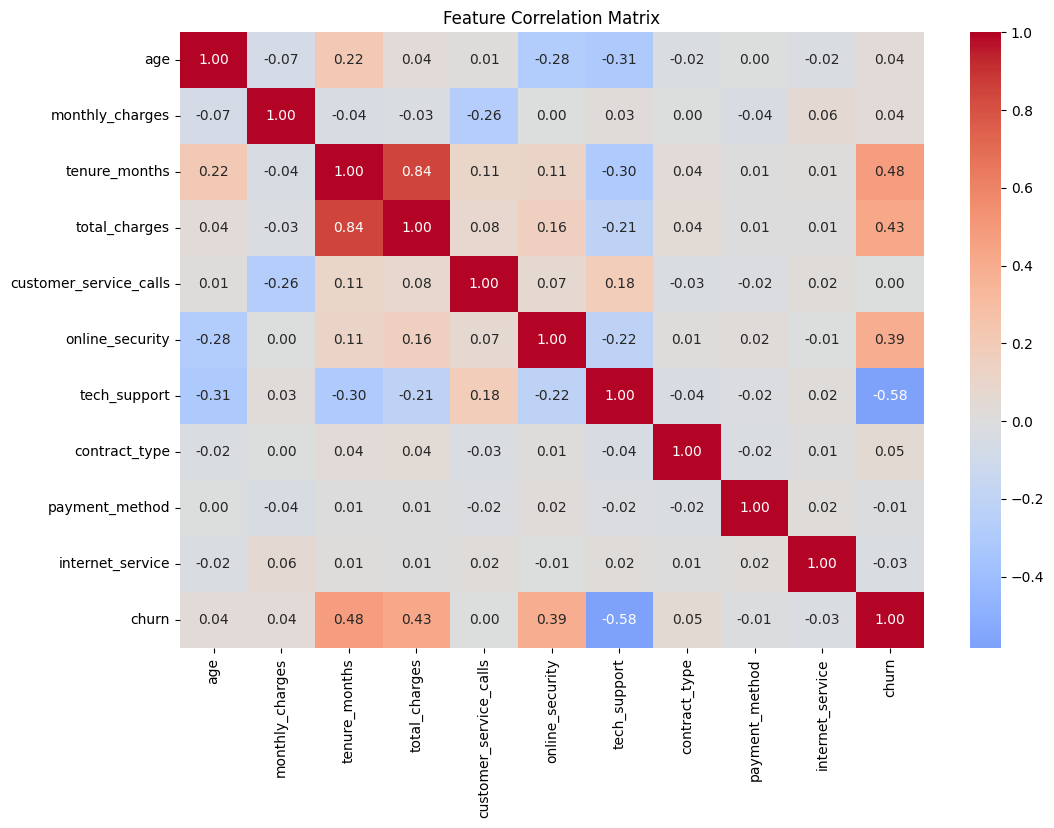

In [14]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

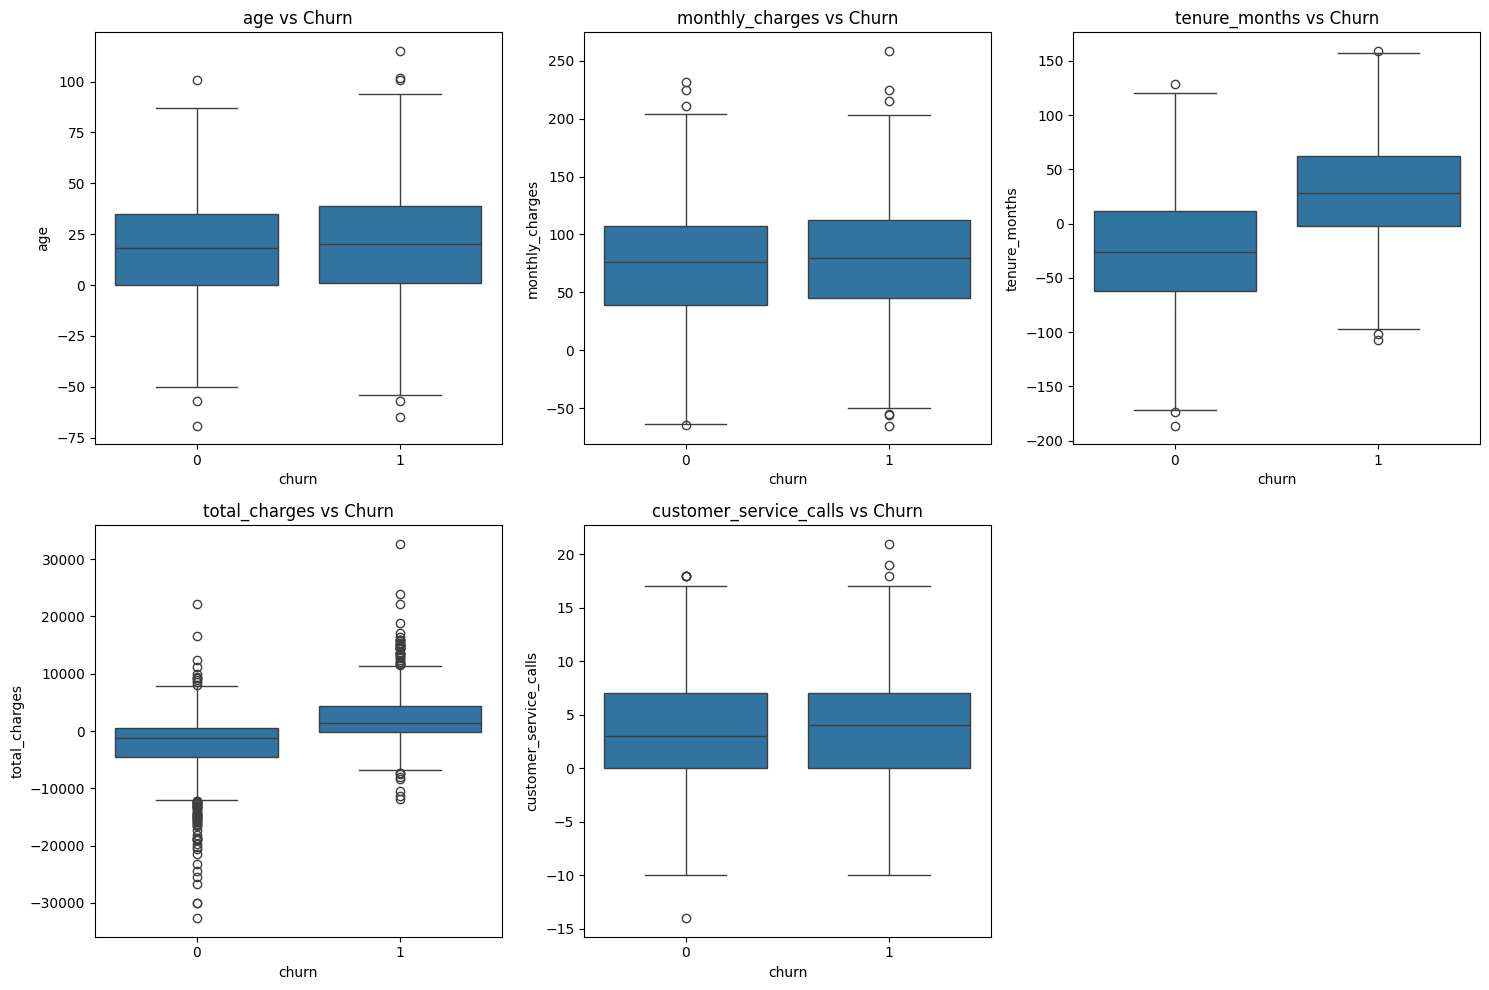

In [15]:
# Box plots for numerical features
numerical_features = ['age', 'monthly_charges', 'tenure_months', 'total_charges', 'customer_service_calls']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='churn', y=feature)
    plt.title(f'{feature} vs Churn')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [17]:
# Separate features and target 
X = df.drop('churn', axis=1)
y = df['churn']

In [18]:
# Check for missing values 
print("Missing values in each column:")
print(X.isnull().sum())

Missing values in each column:
age                       0
monthly_charges           0
tenure_months             0
total_charges             0
customer_service_calls    0
online_security           0
tech_support              0
contract_type             0
payment_method            0
internet_service          0
dtype: int64


In [ ]:
# If there were missing values, we could handle them like this:
# For numerical features


# num_imputer = SimpleImputer(strategy='median')
# X[numerical_features] = num_imputer.fit_transform(X[numerical_features])

# For categorical features  
# cat_imputer = SimpleImputer(strategy='most_frequent')
# X[categorical_features] = cat_imputer.fit_transform(X[categorical_features])

In [20]:
# Identify categorical features (those with limited unique values)

categorical_features = []
for col in X.columns:
    if X[col].nunique() <= 10:   # Arbitrary threshold for categorical features
        categorical_features.append(col)
print("Categorical features identified: ", categorical_features)

Categorical features identified:  ['online_security', 'tech_support', 'contract_type', 'payment_method', 'internet_service']


In [21]:
# For our dataset, we'll treat some features as categorical

categorical_features = ['online_security', 'tech_support', 'contract_type', 
                       'payment_method', 'internet_service']

In [22]:
# One-hot encoding for categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"Original features: {X.shape[1]}")
print(f"After encoding: {X_encoded.shape[1]}")
print("Encoded feature names:", X_encoded.columns.tolist())

Original features: 10
After encoding: 14
Encoded feature names: ['age', 'monthly_charges', 'tenure_months', 'total_charges', 'customer_service_calls', 'online_security_1', 'tech_support_1', 'contract_type_1', 'contract_type_2', 'payment_method_1', 'payment_method_2', 'payment_method_3', 'internet_service_1', 'internet_service_2']


# Feature Scaling

In [25]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
X_scaled = scaler.fit_transform(X_encoded)

# Convert back to DataFrame for better readability
X_scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)

print("=== FEATURE SCALING COMPLETED ===")
print('Original data range (first 5 rows):')
print(X_encoded.iloc[:5, :5])
print('\nScaled data range (first 5 rows):')
print(X_scaled_df.iloc[:5, :5])

=== FEATURE SCALING COMPLETED ===
Original data range (first 5 rows):
   age  monthly_charges  tenure_months  total_charges  customer_service_calls
0   49        88.063767             -2    -176.127535                       4
1   25       118.992418            -25   -2974.810462                       8
2   26       156.302075            -55   -8596.614148                       0
3    0       103.243340            -53   -5471.897022                      -6
4   55        88.153575              0       0.000000                       6

Scaled data range (first 5 rows):
        age  monthly_charges  tenure_months  total_charges  \
0  1.141310         0.217167      -0.064258      -0.035273   
1  0.231265         0.833632      -0.462626      -0.547494   
2  0.269184         1.577283      -0.982236      -1.576407   
3 -0.716698         0.519724      -0.947595      -1.004515   
4  1.368821         0.218957      -0.029618      -0.003038   

   customer_service_calls  
0                0.023536 

# Train-Test Split

In [26]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y,
    test_size=0.2, 
    random_state=42,
    stratify=y  # maintain the same class distribution in train and test sets
)

print("=== TRAIN-TEST SPLIT COMPLETED ===")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training set churn rate: {y_train.mean():.2%}")
print(f"Testing set churn rate: {y_test.mean():.2%}")

=== TRAIN-TEST SPLIT COMPLETED ===
Training set size: 1600 samples
Testing set size: 400 samples
Training set churn rate: 49.88%
Testing set churn rate: 49.75%


# Choosing a Model

For classification problems, Random Forest is a good starting point because:

1. It handles both numerical and categorical features well
2. It's robust to outliers
3. It provides feature importance
4. It generally performs well without extensive tuning

In [27]:
# Initialize the model
model = RandomForestClassifier(random_state=42)

print("Model selected: Random Forest Classifier")
print("This model is good for our problem because:")
print("- Handles complex relationships between features")
print("- Provides feature importance scores")
print("- Robust to overfitting with proper tuning")

Model selected: Random Forest Classifier
This model is good for our problem because:
- Handles complex relationships between features
- Provides feature importance scores
- Robust to overfitting with proper tuning


# Training the Model

In [28]:
# Train the model

model.fit(X_train, y_train)

print("=== MODEL TRAINING COMPLETED ===")
print(f"Model trained on {X_train.shape[0]} samples with {X_train.shape[1]} features.")

=== MODEL TRAINING COMPLETED ===
Model trained on 1600 samples with 14 features.


# Evaluating the Model

In [29]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]    # Probability estimates for the positive class

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== MODEL EVALUATION ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

=== MODEL EVALUATION ===
Accuracy:  0.9075
Precision: 0.9309
Recall:    0.8794
F1-Score:  0.9044


In [30]:
# Detailed classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    No Churn       0.89      0.94      0.91       201
       Churn       0.93      0.88      0.90       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



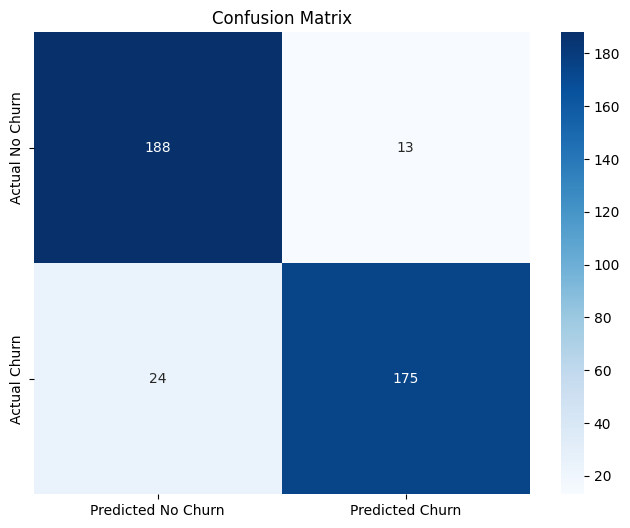

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix')
plt.show()

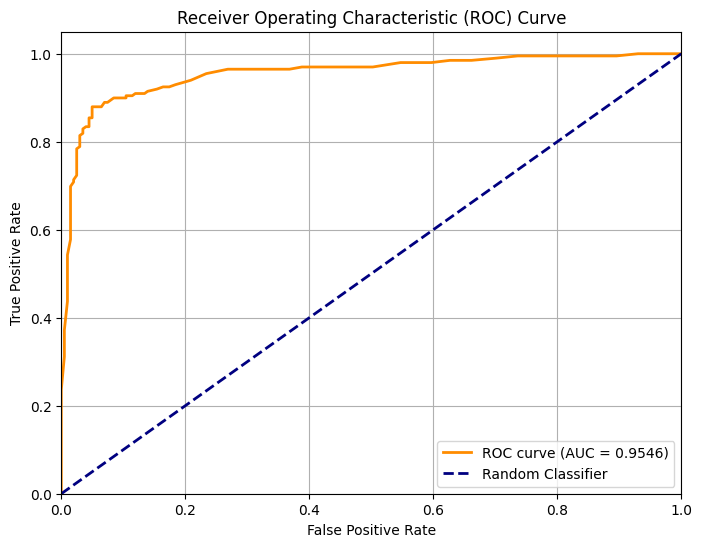

AUC Score: 0.9546


In [33]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")


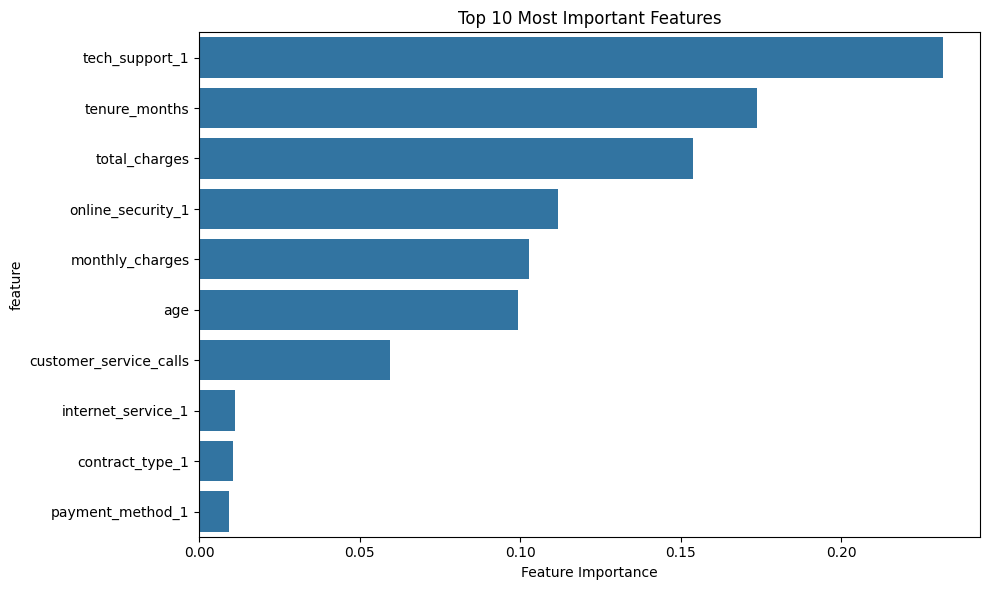


=== TOP 10 FEATURE IMPORTANCES ===
                   feature  importance
6           tech_support_1    0.231611
2            tenure_months    0.173831
3            total_charges    0.153894
5        online_security_1    0.111726
1          monthly_charges    0.102715
0                      age    0.099259
4   customer_service_calls    0.059505
12      internet_service_1    0.011281
7          contract_type_1    0.010544
9         payment_method_1    0.009295


In [34]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("\n=== TOP 10 FEATURE IMPORTANCES ===")
print(feature_importance.head(10))